# 决策树与集成学习 (Decision Trees & Ensemble Learning)

## 学习目标
- 理解决策树的基本原理
- 掌握信息增益和基尼系数
- 理解过拟合问题和剪枝策略
- 掌握Bagging和随机森林
- 理解Boosting原理（AdaBoost、Gradient Boosting）
- 使用XGBoost和LightGBM
- 进行特征重要性分析
- 比较不同集成方法的性能

**预计学习时间：** 4-4.5小时

---

## 1. 决策树理论

### 1.1 什么是决策树？

决策树是一种基于规则的分类和回归算法，通过学习一系列if-then-else决策规则来预测目标变量。

**结构：**
- **根节点(Root Node)**: 包含所有样本
- **内部节点(Internal Node)**: 表示一个特征上的判断
- **分支(Branch)**: 代表判断的结果
- **叶节点(Leaf Node)**: 代表最终的预测结果

---

### 1.2 如何构建决策树？

**核心问题：** 如何选择最优的分裂特征和分裂点？

**基本算法（递归）：**
1. 选择最优特征进行分裂
2. 将数据集分成子集
3. 对每个子集递归执行步骤1-2
4. 满足停止条件时创建叶节点

**停止条件：**
- 所有样本属于同一类别
- 没有更多特征可用
- 达到最大深度
- 节点样本数少于阈值

---

### 1.3 分裂标准

#### 信息增益 (Information Gain)

基于**熵(Entropy)**的概念：

$$H(S) = -\sum_{i=1}^{c} p_i \log_2(p_i)$$

其中 $p_i$ 是类别 $i$ 的比例。

**信息增益：**

$$IG(S, A) = H(S) - \sum_{v \in Values(A)} \frac{|S_v|}{|S|} H(S_v)$$

- 选择信息增益最大的特征进行分裂
- ID3和C4.5算法使用

---

#### 基尼系数 (Gini Impurity)

$$Gini(S) = 1 - \sum_{i=1}^{c} p_i^2$$

**基尼增益：**

$$\Delta Gini = Gini(S) - \sum_{v \in Values(A)} \frac{|S_v|}{|S|} Gini(S_v)$$

- 选择基尼增益最大的特征
- CART算法使用
- 计算更快，通常首选

---

### 1.4 剪枝策略

**为什么需要剪枝？**
- 决策树容易过拟合（学习过于具体的规则）

**预剪枝(Pre-pruning)：**
- 在构建时就限制树的生长
- 参数：`max_depth`, `min_samples_split`, `min_samples_leaf`

**后剪枝(Post-pruning)：**
- 先构建完整树，再删除不必要的子树
- 使用验证集评估剪枝效果

---

### 1.5 决策树的优缺点

**优点：**
- ✅ 易于理解和解释（可视化直观）
- ✅ 无需特征缩放
- ✅ 可以处理数值和类别特征
- ✅ 可以处理多输出问题
- ✅ 可以捕捉非线性关系

**缺点：**
- ❌ 容易过拟合
- ❌ 对数据变化敏感（不稳定）
- ❌ 可能创建偏斜树
- ❌ 贪心算法不保证全局最优

---

## 2. 导入必要的库

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification, load_iris, load_wine
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    VotingClassifier
)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# 设置随机种子
np.random.seed(42)

# 设置绘图风格
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')
plt.rcParams['font.sans-serif'] = [
    'Arial Unicode MS',
    'PingFang SC',
    'STHeiti',
    'Heiti TC',
    'SimHei',
]
plt.rcParams['axes.unicode_minus'] = False

print('✓ 所有库导入成功')

✓ 所有库导入成功


## 3. 决策树实战

### 3.1 生成数据集

训练集: (240, 2)
测试集: (60, 2)


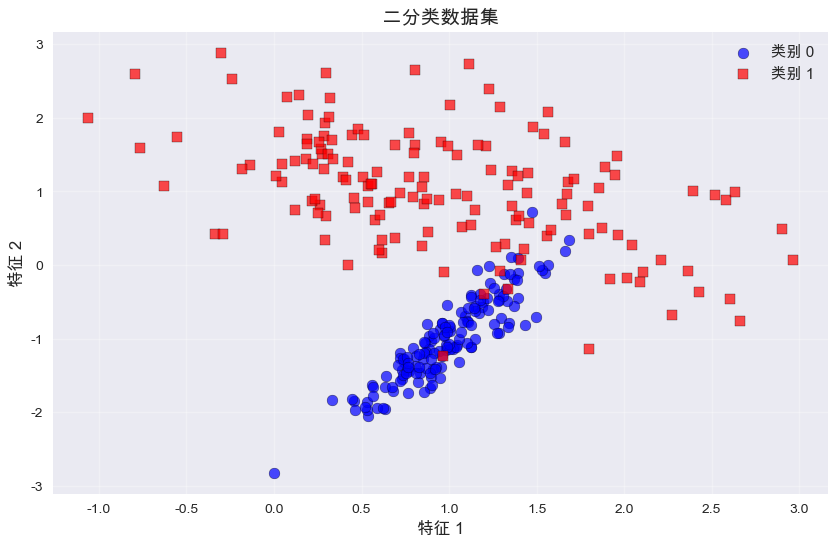

In [2]:
# 生成二分类数据
X, y = make_classification(
    n_samples=300,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_clusters_per_class=1,
    random_state=42
)

# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f'训练集: {X_train.shape}')
print(f'测试集: {X_test.shape}')

# 可视化数据
plt.figure(figsize=(10, 6))
plt.scatter(X[y==0][:, 0], X[y==0][:, 1],
            c='blue', marker='o', s=60, alpha=0.7, edgecolors='k', label='类别 0')
plt.scatter(X[y==1][:, 0], X[y==1][:, 1],
            c='red', marker='s', s=60, alpha=0.7, edgecolors='k', label='类别 1')
plt.xlabel('特征 1', fontsize=12)
plt.ylabel('特征 2', fontsize=12)
plt.title('二分类数据集', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

### 3.2 训练决策树

In [3]:
# 创建决策树模型
tree = DecisionTreeClassifier(
    criterion='gini',      # 分裂标准: 'gini' 或 'entropy'
    max_depth=3,           # 最大深度
    min_samples_split=2,   # 分裂所需的最小样本数
    min_samples_leaf=1,    # 叶节点的最小样本数
    random_state=42
)

# 训练
tree.fit(X_train, y_train)

# 预测
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

# 评估
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print('决策树性能:')
print(f'  训练集准确率: {train_acc:.4f}')
print(f'  测试集准确率: {test_acc:.4f}')

# 树的信息
print(f'\n树的信息:')
print(f'  深度: {tree.get_depth()}')
print(f'  叶节点数: {tree.get_n_leaves()}')
print(f'  节点总数: {tree.tree_.node_count}')

决策树性能:
  训练集准确率: 0.9625
  测试集准确率: 0.9833

树的信息:
  深度: 3
  叶节点数: 7
  节点总数: 13


### 3.3 可视化决策树

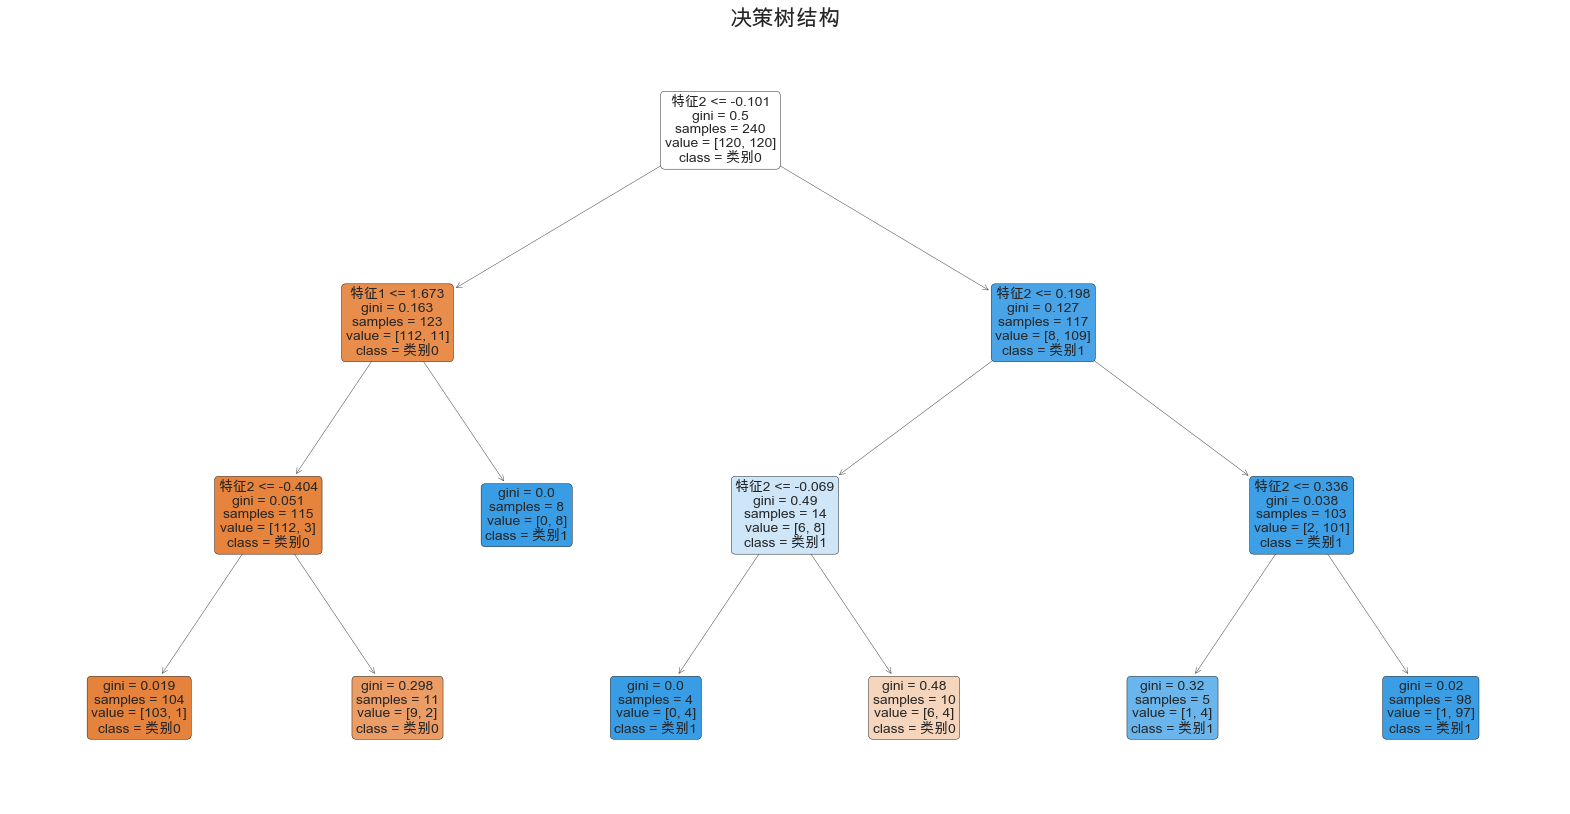


决策树节点解读:
  - 第一行: 分裂条件（例如：特征1 <= 0.5）
  - gini: 基尼系数（不纯度）
  - samples: 该节点的样本数
  - value: 各类别的样本数 [类别0, 类别1]
  - class: 该节点的预测类别
  - 颜色: 橙色偏向类别0，蓝色偏向类别1


In [4]:
# 可视化决策树结构
plt.figure(figsize=(20, 10))
plot_tree(
    tree,
    feature_names=['特征1', '特征2'],
    class_names=['类别0', '类别1'],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title('决策树结构', fontsize=16)
plt.show()

print('\n决策树节点解读:')
print('  - 第一行: 分裂条件（例如：特征1 <= 0.5）')
print('  - gini: 基尼系数（不纯度）')
print('  - samples: 该节点的样本数')
print('  - value: 各类别的样本数 [类别0, 类别1]')
print('  - class: 该节点的预测类别')
print('  - 颜色: 橙色偏向类别0，蓝色偏向类别1')

### 3.4 可视化决策边界

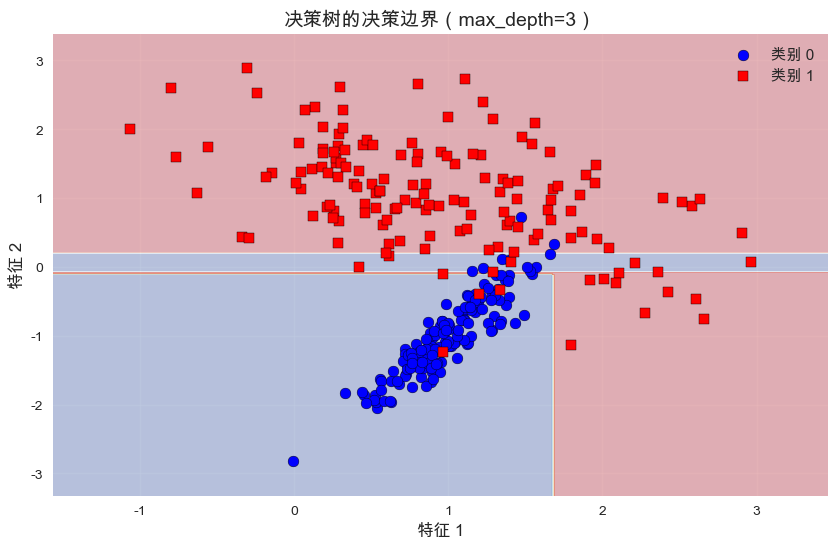


决策边界特点:
  - 决策树的边界是轴平行的（沿着特征轴）
  - 边界由一系列矩形区域组成
  - 这是因为每次分裂只基于单个特征的阈值


In [5]:
def plot_decision_boundary(model, X, y, title='决策边界'):
    """绘制决策边界"""
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu_r')
    plt.scatter(X[y==0][:, 0], X[y==0][:, 1],
                c='blue', marker='o', s=60, edgecolors='k', label='类别 0')
    plt.scatter(X[y==1][:, 0], X[y==1][:, 1],
                c='red', marker='s', s=60, edgecolors='k', label='类别 1')
    plt.xlabel('特征 1', fontsize=12)
    plt.ylabel('特征 2', fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.show()

plot_decision_boundary(tree, X, y, title='决策树的决策边界（max_depth=3）')

print('\n决策边界特点:')
print('  - 决策树的边界是轴平行的（沿着特征轴）')
print('  - 边界由一系列矩形区域组成')
print('  - 这是因为每次分裂只基于单个特征的阈值')

### 3.5 深度对过拟合的影响

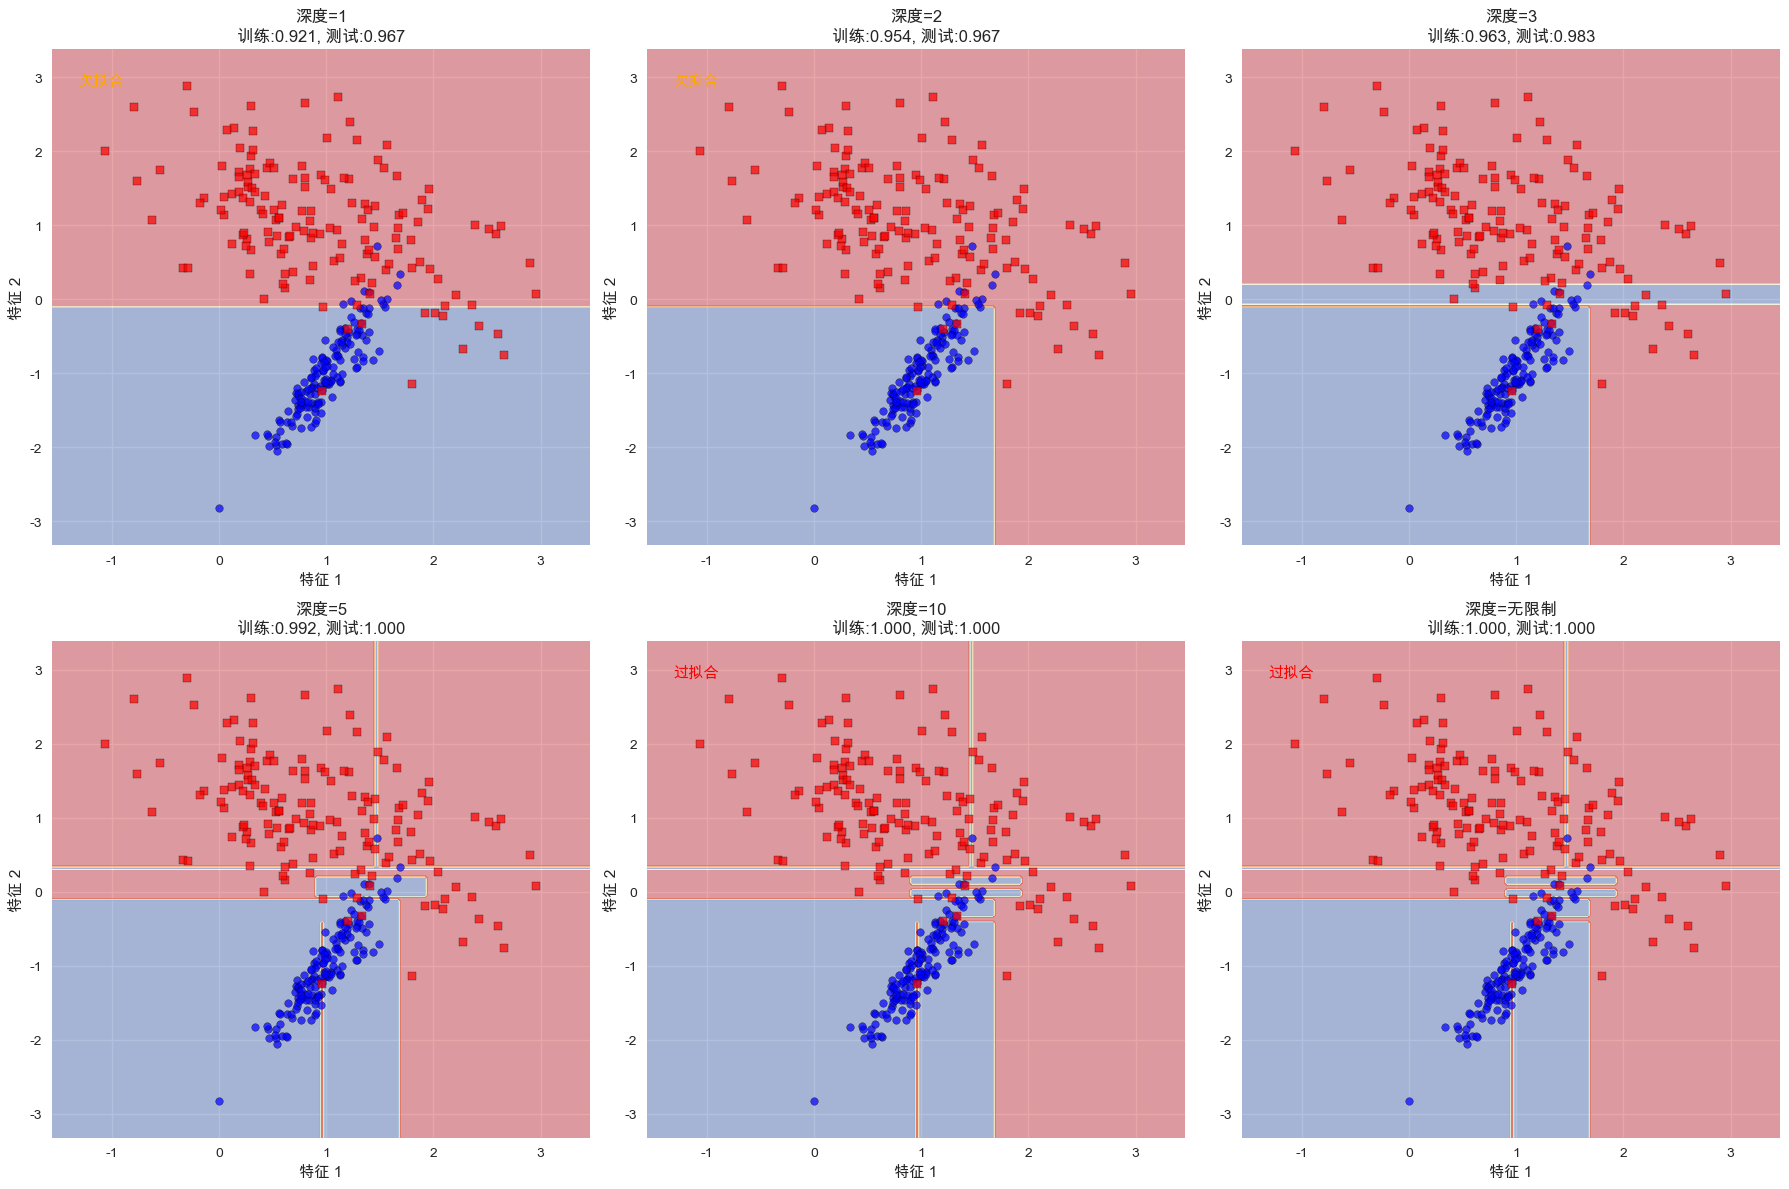

In [6]:
# 测试不同深度
depths = [1, 2, 3, 5, 10, None]
depth_names = ['1', '2', '3', '5', '10', '无限制']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

train_scores = []
test_scores = []

for i, (depth, name) in enumerate(zip(depths, depth_names)):
    # 训练模型
    model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    model.fit(X_train, y_train)
    
    # 评估
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    
    # 创建网格
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # 绘图
    axes[i].contourf(xx, yy, Z, alpha=0.4, cmap='RdYlBu_r')
    axes[i].scatter(X[y==0][:, 0], X[y==0][:, 1],
                    c='blue', marker='o', s=30, edgecolors='k', alpha=0.7)
    axes[i].scatter(X[y==1][:, 0], X[y==1][:, 1],
                    c='red', marker='s', s=30, edgecolors='k', alpha=0.7)
    axes[i].set_title(f'深度={name}\n训练:{train_score:.3f}, 测试:{test_score:.3f}',
                      fontsize=12)
    axes[i].set_xlabel('特征 1')
    axes[i].set_ylabel('特征 2')
    
    # 标注过拟合
    if depth is None or depth >= 10:
        axes[i].text(0.05, 0.95, '过拟合', transform=axes[i].transAxes,
                     fontsize=11, color='red', verticalalignment='top')
    elif depth <= 2:
        axes[i].text(0.05, 0.95, '欠拟合', transform=axes[i].transAxes,
                     fontsize=11, color='orange', verticalalignment='top')

plt.tight_layout()
plt.show()

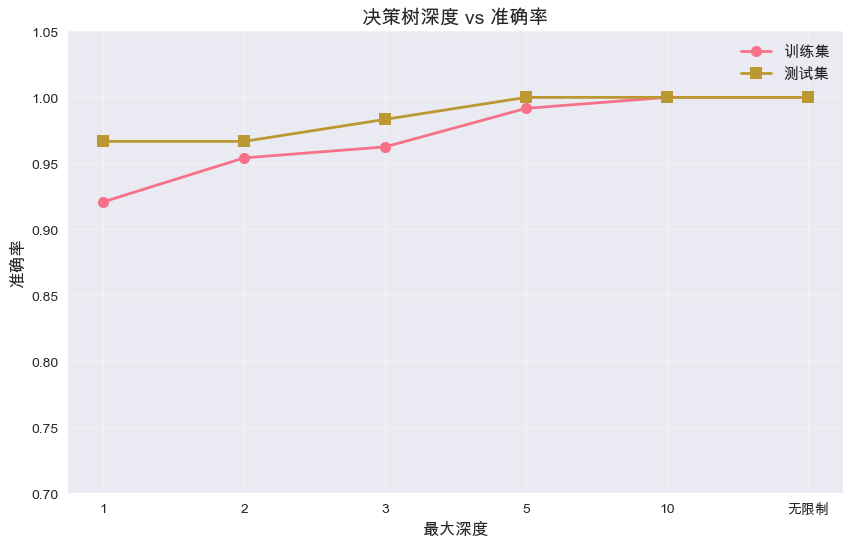


观察:
  - 深度增加，训练准确率持续提高
  - 测试准确率先上升后下降（过拟合）
  - 最佳深度通常在中间值


In [7]:
# 绘制深度vs准确率曲线
plt.figure(figsize=(10, 6))
x_pos = range(len(depth_names))
plt.plot(x_pos, train_scores, 'o-', linewidth=2, markersize=8, label='训练集')
plt.plot(x_pos, test_scores, 's-', linewidth=2, markersize=8, label='测试集')
plt.xticks(x_pos, depth_names)
plt.xlabel('最大深度', fontsize=12)
plt.ylabel('准确率', fontsize=12)
plt.title('决策树深度 vs 准确率', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.ylim([0.7, 1.05])
plt.show()

print('\n观察:')
print('  - 深度增加，训练准确率持续提高')
print('  - 测试准确率先上升后下降（过拟合）')
print('  - 最佳深度通常在中间值')

## 4. 集成学习 - Bagging与随机森林

### 4.1 Bagging原理

**Bagging (Bootstrap Aggregating):**
1. 从训练集中有放回地随机抽取多个子集（Bootstrap采样）
2. 在每个子集上训练一个基学习器
3. 将所有基学习器的预测结果进行投票（分类）或平均（回归）

**优点：**
- 减少方差，降低过拟合
- 可以并行训练
- 对噪声数据鲁棒

---

### 4.2 随机森林

**Random Forest = Bagging + 特征随机性**

在Bagging基础上，每次分裂时只考虑随机选择的一部分特征：
- 进一步增加多样性
- 减少树之间的相关性
- 提高泛化能力

**关键参数：**
- `n_estimators`: 树的数量
- `max_features`: 每次分裂考虑的特征数
  - `'sqrt'`: $\sqrt{n_{features}}$ (分类默认)
  - `'log2'`: $\log_2(n_{features})$
  - 整数或浮点数
- `max_depth`: 树的最大深度
- `min_samples_split`: 分裂所需的最小样本数

---

### 4.3 训练随机森林

In [8]:
# 创建随机森林模型
rf = RandomForestClassifier(
    n_estimators=100,      # 树的数量
    max_depth=5,           # 最大深度
    max_features='sqrt',   # 每次分裂考虑的特征数
    random_state=42,
    n_jobs=-1              # 使用所有CPU核心
)

# 训练
rf.fit(X_train, y_train)

# 预测
y_train_pred_rf = rf.predict(X_train)
y_test_pred_rf = rf.predict(X_test)

# 评估
train_acc_rf = accuracy_score(y_train, y_train_pred_rf)
test_acc_rf = accuracy_score(y_test, y_test_pred_rf)

print('随机森林性能:')
print(f'  训练集准确率: {train_acc_rf:.4f}')
print(f'  测试集准确率: {test_acc_rf:.4f}')

print('\n对比单棵决策树:')
print(f'  决策树测试准确率: {test_acc:.4f}')
print(f'  随机森林测试准确率: {test_acc_rf:.4f}')
print(f'  提升: {(test_acc_rf - test_acc)*100:.2f}%')

随机森林性能:
  训练集准确率: 0.9792
  测试集准确率: 1.0000

对比单棵决策树:
  决策树测试准确率: 0.9833
  随机森林测试准确率: 1.0000
  提升: 1.67%


### 4.4 可视化随机森林决策边界

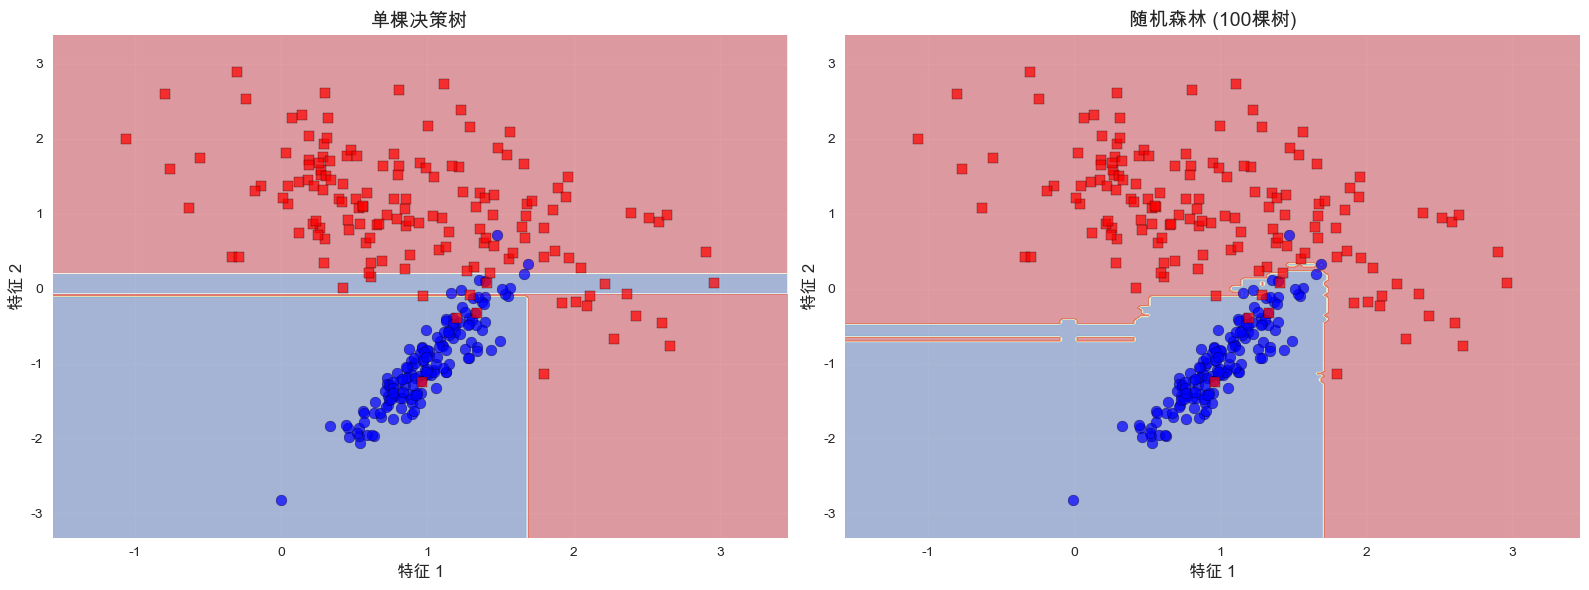


观察:
  - 单棵树: 边界有明显的轴平行特征
  - 随机森林: 边界更平滑，过拟合减少


In [9]:
# 对比单棵树和随机森林
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

models = [tree, rf]
titles = ['单棵决策树', '随机森林 (100棵树)']

for ax, model, title in zip(axes, models, titles):
    # 创建网格
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # 绘图
    ax.contourf(xx, yy, Z, alpha=0.4, cmap='RdYlBu_r')
    ax.scatter(X[y==0][:, 0], X[y==0][:, 1],
               c='blue', marker='o', s=60, edgecolors='k', alpha=0.7)
    ax.scatter(X[y==1][:, 0], X[y==1][:, 1],
               c='red', marker='s', s=60, edgecolors='k', alpha=0.7)
    ax.set_xlabel('特征 1', fontsize=12)
    ax.set_ylabel('特征 2', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print('\n观察:')
print('  - 单棵树: 边界有明显的轴平行特征')
print('  - 随机森林: 边界更平滑，过拟合减少')

### 4.5 树的数量的影响

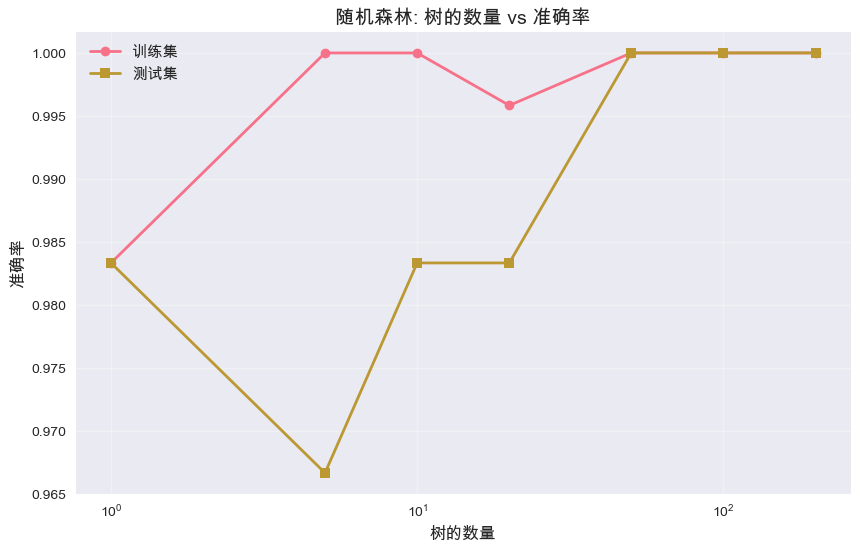


结论:
  - 树越多，性能越好，但收益递减
  - 通常50-200棵树就足够
  - 更多的树会增加计算时间


In [10]:
# 测试不同数量的树
n_estimators_list = [1, 5, 10, 20, 50, 100, 200]
train_scores_rf = []
test_scores_rf = []

for n_est in n_estimators_list:
    rf_temp = RandomForestClassifier(n_estimators=n_est, random_state=42, n_jobs=-1)
    rf_temp.fit(X_train, y_train)
    train_scores_rf.append(rf_temp.score(X_train, y_train))
    test_scores_rf.append(rf_temp.score(X_test, y_test))

# 绘图
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_list, train_scores_rf, 'o-', linewidth=2, label='训练集')
plt.plot(n_estimators_list, test_scores_rf, 's-', linewidth=2, label='测试集')
plt.xlabel('树的数量', fontsize=12)
plt.ylabel('准确率', fontsize=12)
plt.title('随机森林: 树的数量 vs 准确率', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xscale('log')
plt.show()

print('\n结论:')
print('  - 树越多，性能越好，但收益递减')
print('  - 通常50-200棵树就足够')
print('  - 更多的树会增加计算时间')

### 4.6 特征重要性分析

特征重要性:
               特征      重要性
petal length (cm) 0.436130
 petal width (cm) 0.436065
sepal length (cm) 0.106128
 sepal width (cm) 0.021678


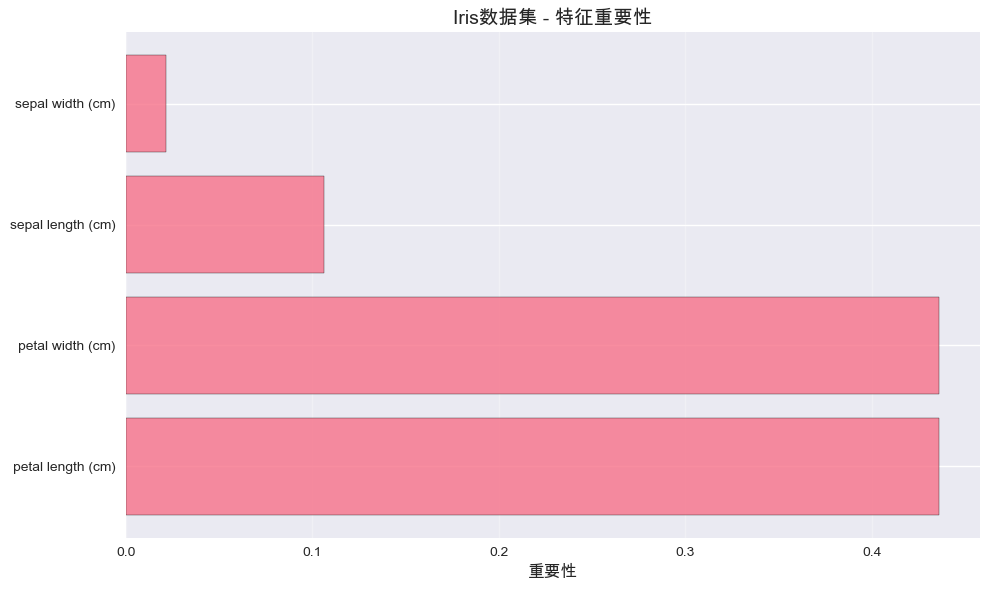


解释:
  - 特征重要性基于该特征在所有树中的平均不纯度减少量
  - 重要性越高，特征对预测的贡献越大
  - 可用于特征选择


In [11]:
# 使用Iris数据集进行特征重要性分析
iris = load_iris()
X_iris = iris.data
y_iris = iris.target

# 训练随机森林
rf_iris = RandomForestClassifier(n_estimators=100, random_state=42)
rf_iris.fit(X_iris, y_iris)

# 获取特征重要性
feature_importance = pd.DataFrame({
    '特征': iris.feature_names,
    '重要性': rf_iris.feature_importances_
}).sort_values('重要性', ascending=False)

print('特征重要性:')
print(feature_importance.to_string(index=False))

# 可视化
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importance)), feature_importance['重要性'],
         alpha=0.8, edgecolor='black')
plt.yticks(range(len(feature_importance)), feature_importance['特征'])
plt.xlabel('重要性', fontsize=12)
plt.title('Iris数据集 - 特征重要性', fontsize=14)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print('\n解释:')
print('  - 特征重要性基于该特征在所有树中的平均不纯度减少量')
print('  - 重要性越高，特征对预测的贡献越大')
print('  - 可用于特征选择')

## 5. 集成学习 - Boosting

### 5.1 Boosting原理

**Boosting的核心思想：**
- 串行训练多个弱学习器
- 每个新学习器关注前一个学习器的错误
- 最终加权组合所有学习器

**Bagging vs Boosting:**

| 特性 | Bagging | Boosting |
|------|---------|----------|
| 训练方式 | 并行 | 串行 |
| 样本权重 | 均等 | 调整 |
| 目标 | 减少方差 | 减少偏差 |
| 代表算法 | 随机森林 | AdaBoost, GBDT, XGBoost |

---

### 5.2 AdaBoost

**AdaBoost (Adaptive Boosting) 算法：**

1. 初始化样本权重为均等
2. 训练弱学习器
3. 计算学习器的错误率和权重
4. 更新样本权重（错误样本权重增加）
5. 重复2-4，直到达到指定数量
6. 加权组合所有学习器

---

### 5.3 Gradient Boosting

**梯度提升决策树(GBDT)：**
- 每个新树拟合前一个模型的残差（梯度）
- 使用梯度下降优化损失函数
- 更强大、更灵活

**关键参数：**
- `n_estimators`: 树的数量
- `learning_rate`: 学习率（每棵树的贡献）
- `max_depth`: 树的深度（通常较小，3-5）
- `subsample`: 子样本比例

---

### 5.4 训练AdaBoost

In [12]:
# 创建AdaBoost模型
ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),  # 使用决策树桩（深度1）
    n_estimators=50,
    learning_rate=1.0,
    random_state=42
)

# 训练
ada.fit(X_train, y_train)

# 评估
train_acc_ada = ada.score(X_train, y_train)
test_acc_ada = ada.score(X_test, y_test)

print('AdaBoost性能:')
print(f'  训练集准确率: {train_acc_ada:.4f}')
print(f'  测试集准确率: {test_acc_ada:.4f}')

AdaBoost性能:
  训练集准确率: 1.0000
  测试集准确率: 0.9833


### 5.5 训练Gradient Boosting

In [13]:
# 创建Gradient Boosting模型
gb = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    random_state=42
)

# 训练
gb.fit(X_train, y_train)

# 评估
train_acc_gb = gb.score(X_train, y_train)
test_acc_gb = gb.score(X_test, y_test)

print('Gradient Boosting性能:')
print(f'  训练集准确率: {train_acc_gb:.4f}')
print(f'  测试集准确率: {test_acc_gb:.4f}')

Gradient Boosting性能:
  训练集准确率: 1.0000
  测试集准确率: 1.0000


### 5.6 XGBoost和LightGBM

**XGBoost (Extreme Gradient Boosting):**
- GBDT的高效实现
- 支持并行计算
- 内置正则化
- 处理缺失值
- Kaggle竞赛最流行

**LightGBM (Light Gradient Boosting Machine):**
- 微软开源
- 更快的训练速度
- 更低的内存占用
- 支持大数据集
- 基于直方图的算法

---

In [15]:
# 尝试导入XGBoost和LightGBM
try:
    import xgboost as xgb
    xgboost_available = True
    print('✓ XGBoost已安装')
except ImportError:
    xgboost_available = False
    print('✗ XGBoost未安装。安装命令: pip install xgboost')

try:
    import lightgbm as lgb
    lightgbm_available = True
    print('✓ LightGBM已安装')
except ImportError:
    lightgbm_available = False
    print('✗ LightGBM未安装。安装命令: pip install lightgbm')

✓ XGBoost已安装
✓ LightGBM已安装


In [16]:
# 如果XGBoost可用，训练模型
if xgboost_available:
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        random_state=42
    )
    xgb_model.fit(X_train, y_train)
    
    train_acc_xgb = xgb_model.score(X_train, y_train)
    test_acc_xgb = xgb_model.score(X_test, y_test)
    
    print('\nXGBoost性能:')
    print(f'  训练集准确率: {train_acc_xgb:.4f}')
    print(f'  测试集准确率: {test_acc_xgb:.4f}')
else:
    print('\n跳过XGBoost演示（未安装）')
    test_acc_xgb = None


XGBoost性能:
  训练集准确率: 0.9792
  测试集准确率: 0.9667


In [17]:
# 如果LightGBM可用，训练模型
if lightgbm_available:
    lgb_model = lgb.LGBMClassifier(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        random_state=42,
        verbose=-1  # 关闭输出
    )
    lgb_model.fit(X_train, y_train)
    
    train_acc_lgb = lgb_model.score(X_train, y_train)
    test_acc_lgb = lgb_model.score(X_test, y_test)
    
    print('\nLightGBM性能:')
    print(f'  训练集准确率: {train_acc_lgb:.4f}')
    print(f'  测试集准确率: {test_acc_lgb:.4f}')
else:
    print('\n跳过LightGBM演示（未安装）')
    test_acc_lgb = None


LightGBM性能:
  训练集准确率: 0.9958
  测试集准确率: 0.9667


### 5.7 所有模型对比


模型性能对比
               模型    测试准确率
             随机森林 1.000000
Gradient Boosting 1.000000
              决策树 0.983333
         AdaBoost 0.983333
          XGBoost 0.966667
         LightGBM 0.966667


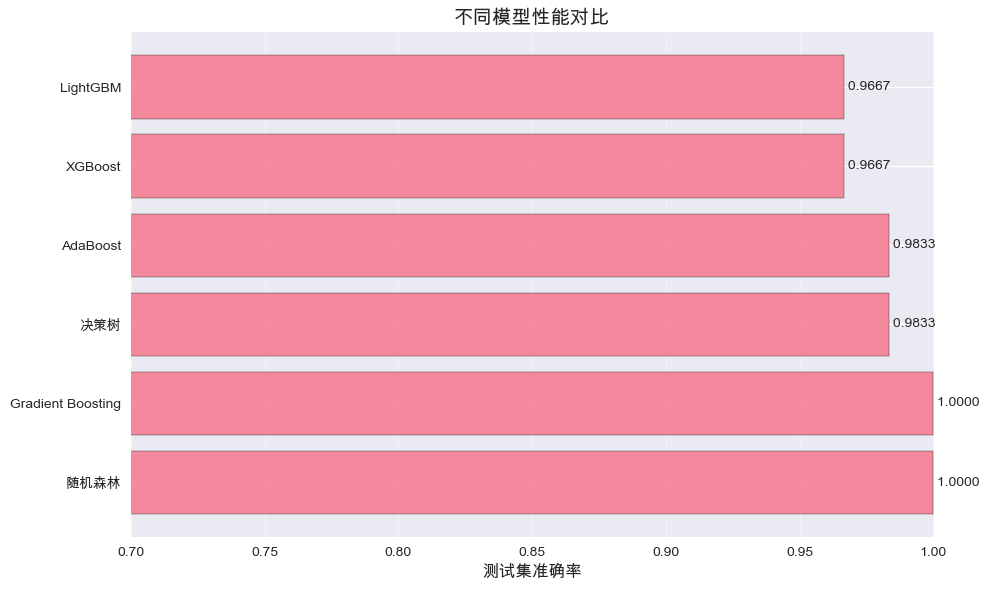

In [18]:
# 汇总结果
results = pd.DataFrame({
    '模型': ['决策树', '随机森林', 'AdaBoost', 'Gradient Boosting'],
    '测试准确率': [test_acc, test_acc_rf, test_acc_ada, test_acc_gb]
})

if test_acc_xgb is not None:
    results = pd.concat([results, pd.DataFrame({
        '模型': ['XGBoost'],
        '测试准确率': [test_acc_xgb]
    })], ignore_index=True)

if test_acc_lgb is not None:
    results = pd.concat([results, pd.DataFrame({
        '模型': ['LightGBM'],
        '测试准确率': [test_acc_lgb]
    })], ignore_index=True)

results = results.sort_values('测试准确率', ascending=False).reset_index(drop=True)

print('\n' + '='*50)
print('模型性能对比')
print('='*50)
print(results.to_string(index=False))
print('='*50)

# 可视化对比
plt.figure(figsize=(10, 6))
plt.barh(range(len(results)), results['测试准确率'], alpha=0.8, edgecolor='black')
plt.yticks(range(len(results)), results['模型'])
plt.xlabel('测试集准确率', fontsize=12)
plt.title('不同模型性能对比', fontsize=14)
plt.xlim([0.7, 1.0])
plt.grid(True, alpha=0.3, axis='x')

# 添加数值标签
for i, (idx, row) in enumerate(results.iterrows()):
    plt.text(row['测试准确率'], i, f' {row["测试准确率"]:.4f}',
             va='center', fontsize=10)

plt.tight_layout()
plt.show()

## 6. Wine数据集综合实战

### 6.1 加载和探索数据

In [19]:
# 加载Wine数据集
wine = load_wine()
X_wine = wine.data
y_wine = wine.target

print('Wine数据集信息:')
print(f'  样本数: {len(X_wine)}')
print(f'  特征数: {X_wine.shape[1]}')
print(f'  类别数: {len(np.unique(y_wine))}')
print(f'  类别名称: {wine.target_names}')
print(f'\n特征名称:')
for i, name in enumerate(wine.feature_names, 1):
    print(f'  {i}. {name}')

print(f'\n类别分布:')
for i, name in enumerate(wine.target_names):
    count = np.sum(y_wine == i)
    print(f'  {name}: {count}')

Wine数据集信息:
  样本数: 178
  特征数: 13
  类别数: 3
  类别名称: ['class_0' 'class_1' 'class_2']

特征名称:
  1. alcohol
  2. malic_acid
  3. ash
  4. alcalinity_of_ash
  5. magnesium
  6. total_phenols
  7. flavanoids
  8. nonflavanoid_phenols
  9. proanthocyanins
  10. color_intensity
  11. hue
  12. od280/od315_of_diluted_wines
  13. proline

类别分布:
  class_0: 59
  class_1: 71
  class_2: 48


In [20]:
# 划分数据集
X_train_wine, X_test_wine, y_train_wine, y_test_wine = train_test_split(
    X_wine, y_wine, test_size=0.2, random_state=42, stratify=y_wine
)

print(f'训练集: {X_train_wine.shape}')
print(f'测试集: {X_test_wine.shape}')

训练集: (142, 13)
测试集: (36, 13)


### 6.2 训练多个模型并对比

In [21]:
# 定义多个模型
models = {
    '决策树': DecisionTreeClassifier(max_depth=5, random_state=42),
    '随机森林': RandomForestClassifier(n_estimators=100, random_state=42),
    'AdaBoost': AdaBoostClassifier(n_estimators=50, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

if xgboost_available:
    models['XGBoost'] = xgb.XGBClassifier(n_estimators=100, random_state=42)

if lightgbm_available:
    models['LightGBM'] = lgb.LGBMClassifier(n_estimators=100, random_state=42, verbose=-1)

# 训练和评估
results_wine = []

for name, model in models.items():
    # 训练
    model.fit(X_train_wine, y_train_wine)
    
    # 评估
    train_score = model.score(X_train_wine, y_train_wine)
    test_score = model.score(X_test_wine, y_test_wine)
    
    # 交叉验证
    cv_scores = cross_val_score(model, X_train_wine, y_train_wine, cv=5)
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    
    results_wine.append({
        '模型': name,
        '训练准确率': train_score,
        '测试准确率': test_score,
        'CV均值': cv_mean,
        'CV标准差': cv_std
    })
    
    print(f'{name}: 测试={test_score:.4f}, CV={cv_mean:.4f}±{cv_std:.4f}')

# 转换为DataFrame
results_wine_df = pd.DataFrame(results_wine).sort_values('测试准确率', ascending=False)

print('\n' + '='*80)
print('Wine数据集 - 模型性能对比')
print('='*80)
print(results_wine_df.to_string(index=False))
print('='*80)

决策树: 测试=0.9444, CV=0.9163±0.0514
随机森林: 测试=1.0000, CV=0.9862±0.0276
AdaBoost: 测试=0.8333, CV=0.8815±0.0734
Gradient Boosting: 测试=0.9444, CV=0.9584±0.0402
XGBoost: 测试=0.9722, CV=0.9443±0.0517
LightGBM: 测试=1.0000, CV=0.9722±0.0259

Wine数据集 - 模型性能对比
               模型    训练准确率    测试准确率     CV均值    CV标准差
             随机森林 1.000000 1.000000 0.986207 0.027586
         LightGBM 1.000000 1.000000 0.972167 0.025875
          XGBoost 1.000000 0.972222 0.944335 0.051750
              决策树 1.000000 0.944444 0.916256 0.051359
Gradient Boosting 1.000000 0.944444 0.958374 0.040174
         AdaBoost 0.929577 0.833333 0.881527 0.073366


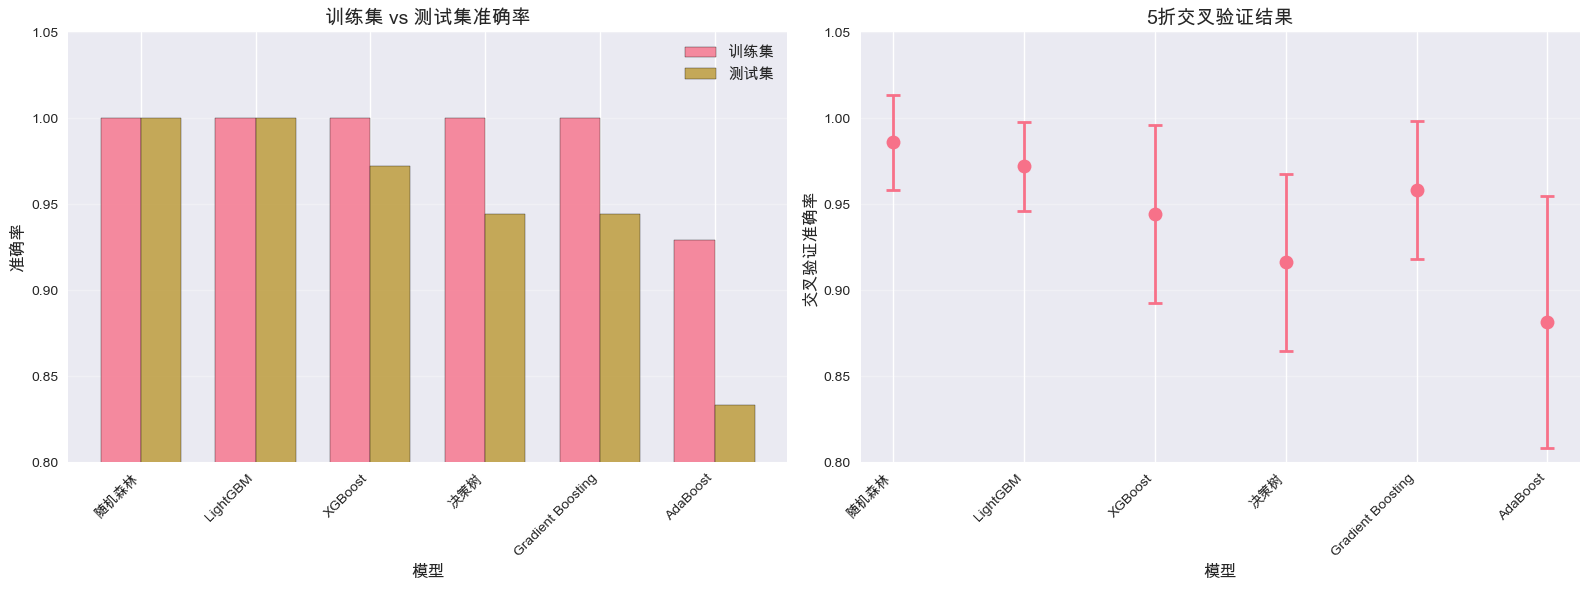

In [22]:
# 可视化对比
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 准确率对比
ax1 = axes[0]
x_pos = np.arange(len(results_wine_df))
width = 0.35

ax1.bar(x_pos - width/2, results_wine_df['训练准确率'], width, 
        label='训练集', alpha=0.8, edgecolor='black')
ax1.bar(x_pos + width/2, results_wine_df['测试准确率'], width,
        label='测试集', alpha=0.8, edgecolor='black')

ax1.set_xlabel('模型', fontsize=12)
ax1.set_ylabel('准确率', fontsize=12)
ax1.set_title('训练集 vs 测试集准确率', fontsize=14)
ax1.set_xticks(x_pos)
ax1.set_xticklabels(results_wine_df['模型'], rotation=45, ha='right')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim([0.8, 1.05])

# 交叉验证结果
ax2 = axes[1]
ax2.errorbar(x_pos, results_wine_df['CV均值'], yerr=results_wine_df['CV标准差'],
             fmt='o', markersize=10, capsize=5, capthick=2, linewidth=2)
ax2.set_xlabel('模型', fontsize=12)
ax2.set_ylabel('交叉验证准确率', fontsize=12)
ax2.set_title('5折交叉验证结果', fontsize=14)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(results_wine_df['模型'], rotation=45, ha='right')
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_ylim([0.8, 1.05])

plt.tight_layout()
plt.show()

### 6.3 特征重要性分析

特征重要性排名:
                          特征      重要性
             color_intensity 0.187580
                  flavanoids 0.159561
                     proline 0.146799
                     alcohol 0.117913
                         hue 0.101538
od280/od315_of_diluted_wines 0.096301
               total_phenols 0.041514
                   magnesium 0.040131
                  malic_acid 0.033894
           alcalinity_of_ash 0.025471
             proanthocyanins 0.023530
                         ash 0.018157
        nonflavanoid_phenols 0.007610


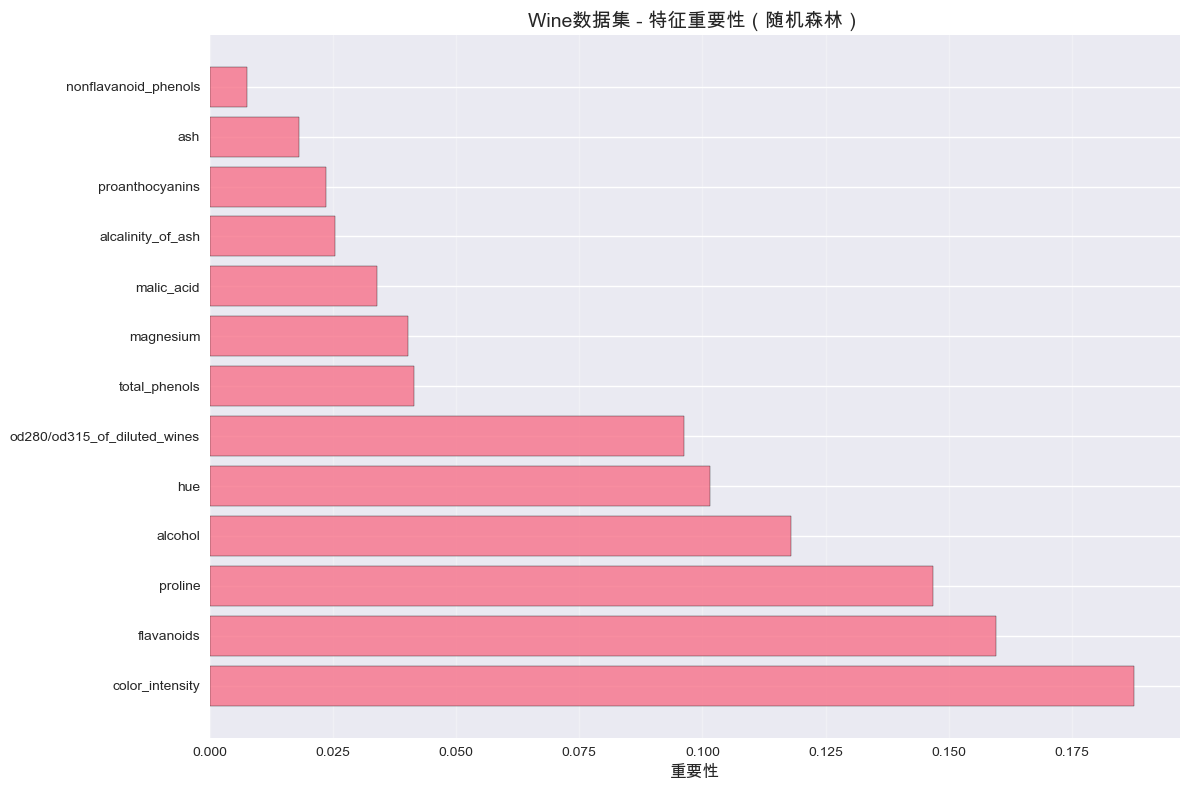


最重要的3个特征:
  1. color_intensity: 0.1876
  2. flavanoids: 0.1596
  3. proline: 0.1468


In [23]:
# 使用随机森林分析特征重要性
rf_wine = models['随机森林']

# 获取特征重要性
feature_importance_wine = pd.DataFrame({
    '特征': wine.feature_names,
    '重要性': rf_wine.feature_importances_
}).sort_values('重要性', ascending=False)

print('特征重要性排名:')
print(feature_importance_wine.to_string(index=False))

# 可视化
plt.figure(figsize=(12, 8))
plt.barh(range(len(feature_importance_wine)), feature_importance_wine['重要性'],
         alpha=0.8, edgecolor='black')
plt.yticks(range(len(feature_importance_wine)), feature_importance_wine['特征'])
plt.xlabel('重要性', fontsize=12)
plt.title('Wine数据集 - 特征重要性（随机森林）', fontsize=14)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print(f'\n最重要的3个特征:')
for i, (idx, row) in enumerate(feature_importance_wine.head(3).iterrows(), 1):
    print(f"  {i}. {row['特征']}: {row['重要性']:.4f}")

### 6.4 混淆矩阵对比

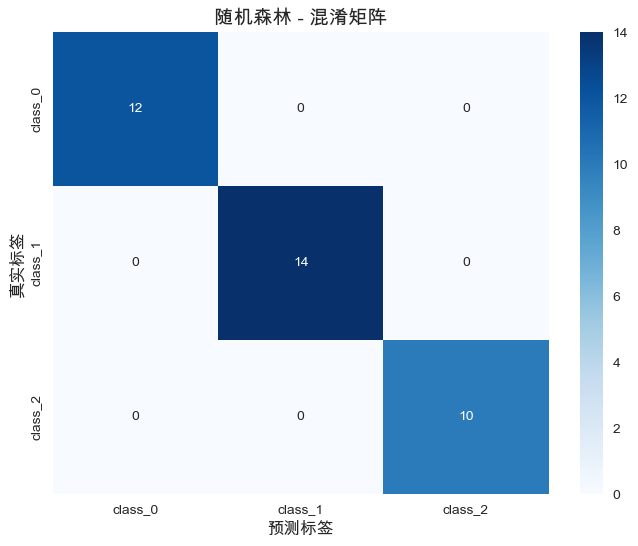


随机森林分类报告:
              precision    recall  f1-score   support

     class_0       1.00      1.00      1.00        12
     class_1       1.00      1.00      1.00        14
     class_2       1.00      1.00      1.00        10

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



In [24]:
# 选择表现最好的模型
best_model_name = results_wine_df.iloc[0]['模型']
best_model = models[best_model_name]

# 预测
y_pred_best = best_model.predict(X_test_wine)

# 混淆矩阵
cm = confusion_matrix(y_test_wine, y_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=wine.target_names,
            yticklabels=wine.target_names)
plt.xlabel('预测标签', fontsize=12)
plt.ylabel('真实标签', fontsize=12)
plt.title(f'{best_model_name} - 混淆矩阵', fontsize=14)
plt.show()

# 分类报告
print(f'\n{best_model_name}分类报告:')
print(classification_report(y_test_wine, y_pred_best, target_names=wine.target_names))

## 7. 练习题

### 练习1: 实现简单的决策树

从零实现一个简单的二叉决策树。

In [ ]:
# TODO: 实现简单决策树
# 提示：
# 1. 实现计算基尼系数的函数
# 2. 实现找最佳分裂点的函数
# 3. 递归构建树

# def gini_impurity(y):
#     # 你的代码...
#     pass

# def find_best_split(X, y):
#     # 你的代码...
#     pass

### 练习2: Voting分类器

组合多个不同类型的分类器（决策树、SVM、逻辑回归）构建Voting分类器。

练习2: Voting分类器

步骤1: 定义基分类器...
  基分类器:
    - 决策树
    - SVM
    - 逻辑回归

步骤2: 创建Voting分类器...
  创建的Voting分类器:
    - Hard Voting (多数投票)
    - Soft Voting (概率平均)

步骤3: 训练和评估所有模型...
  决策树         : 测试=0.9444, CV=0.9163±0.0514
  SVM         : 测试=0.6944, CV=0.6480±0.0371
  逻辑回归        : 测试=0.9722, CV=0.9581±0.0337
  Hard Voting : 测试=0.9444, CV=0.9232±0.0456
  Soft Voting : 测试=0.9722, CV=0.9303±0.0486

性能对比总结
         模型    训练准确率    测试准确率     CV均值    CV标准差
        决策树 1.000000 0.944444 0.916256 0.051359
        SVM 0.676056 0.694444 0.648030 0.037113
       逻辑回归 0.985915 0.972222 0.958128 0.033691
Hard Voting 1.000000 0.944444 0.923153 0.045614
Soft Voting 1.000000 0.972222 0.930296 0.048601


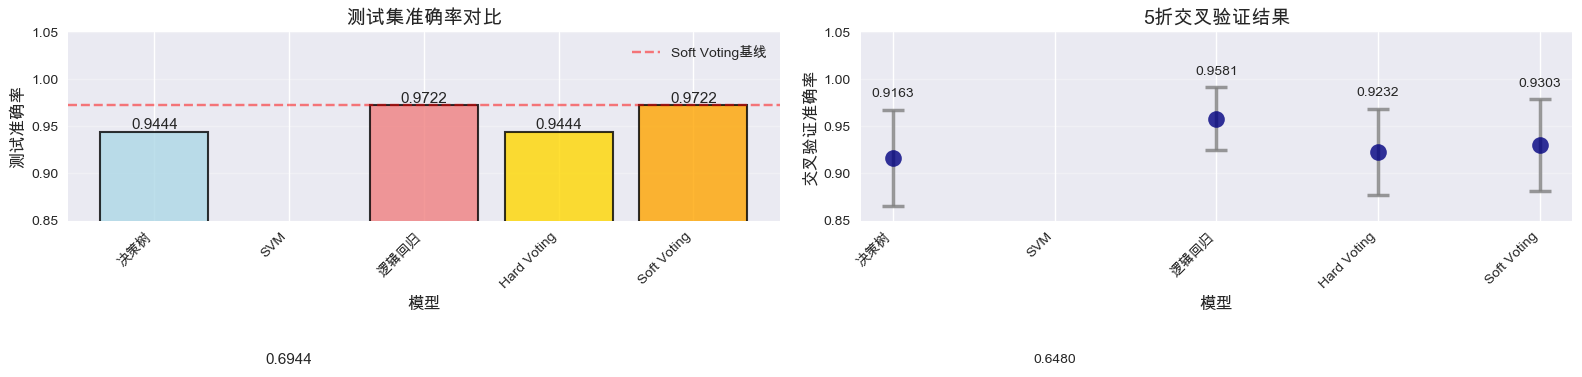


Hard Voting vs Soft Voting 详解

Hard Voting (硬投票):
  原理: 每个分类器投一票，选择得票最多的类别
  公式: argmax(sum(votes))
  测试准确率: 0.9444
  优点: 简单直接，不需要概率估计
  缺点: 忽略了预测的置信度

Soft Voting (软投票):
  原理: 对所有分类器的预测概率求平均，选择平均概率最高的类别
  公式: argmax(mean(probabilities))
  测试准确率: 0.9722
  优点: 考虑了预测置信度，通常性能更好
  缺点: 所有基分类器必须支持概率预测

结论: Soft Voting表现更好 (+2.78%)

额外实验: 加权Voting

基于CV性能的权重:
  决策树: 0.3632
  SVM: 0.2569
  逻辑回归: 0.3798

加权Soft Voting性能:
  测试准确率: 0.9722
  CV均值: 0.9303
  对比普通Soft Voting: +0.00%

额外实验: 添加更多基分类器

扩展Voting分类器 (5个基分类器):
  基分类器: 决策树, SVM, 逻辑回归, 随机森林, 梯度提升
  测试准确率: 0.9722
  CV均值: 0.9512
  对比3分类器Voting: +0.00%

额外验证: Iris数据集
  决策树         : 0.9667
  SVM         : 0.9667
  逻辑回归        : 0.9667
  Soft Voting : 0.9667

步骤9: 生成混淆矩阵...


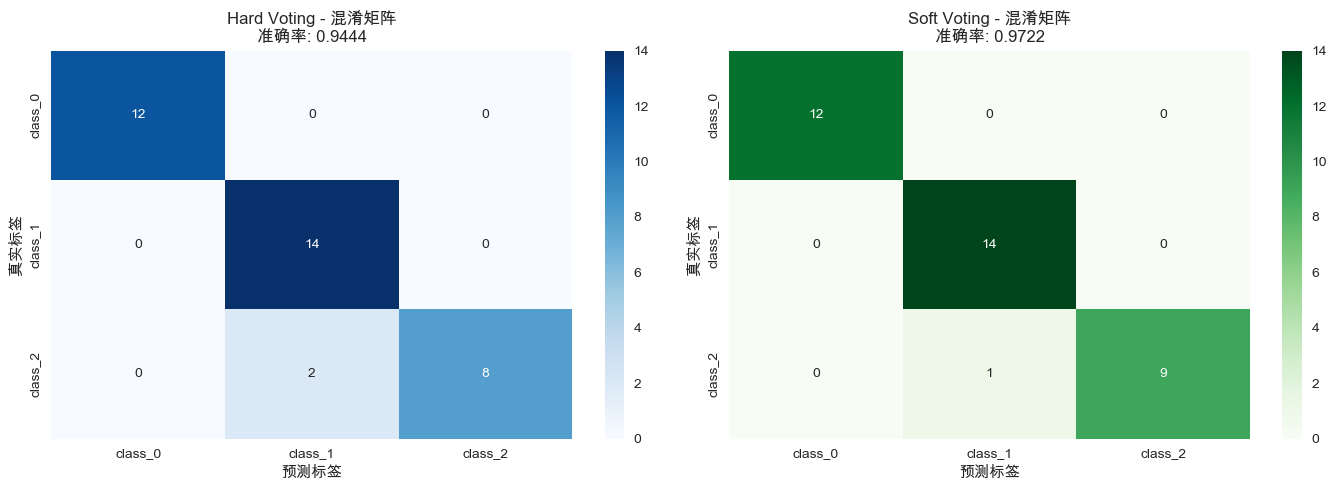


✅ 练习2完成！

关键要点:
  1. Voting原理: 组合多个分类器的预测结果
  2. Hard Voting: 多数投票，简单直接
  3. Soft Voting: 概率平均，通常性能更好
  4. 加权Voting: 根据模型性能设置不同权重
  5. 基分类器选择: 选择多样化的分类器效果更好
  6. 集成优势: Voting通常优于单个分类器

最佳实践:
  ✓ 选择不同类型的基分类器(如决策树+SVM+逻辑回归)
  ✓ 优先使用Soft Voting(如果所有分类器支持概率预测)
  ✓ 根据验证集性能设置权重
  ✓ 确保基分类器有足够的多样性
  ✓ 使用交叉验证评估集成效果


In [25]:
### ========== 练习2解答 ==========

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

print('='*70)
print('练习2: Voting分类器')
print('='*70)

# 1. 定义基分类器
print('\n步骤1: 定义基分类器...')
base_classifiers = {
    '决策树': DecisionTreeClassifier(max_depth=5, random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),  # probability=True用于soft voting
    '逻辑回归': LogisticRegression(max_iter=1000, random_state=42)
}

print('  基分类器:')
for name in base_classifiers.keys():
    print(f'    - {name}')

# 2. 创建Hard Voting分类器
print('\n步骤2: 创建Voting分类器...')

# Hard Voting: 多数投票
voting_hard = VotingClassifier(
    estimators=[
        ('dt', base_classifiers['决策树']),
        ('svm', base_classifiers['SVM']),
        ('lr', base_classifiers['逻辑回归'])
    ],
    voting='hard'  # 硬投票：选择得票最多的类别
)

# Soft Voting: 概率平均
voting_soft = VotingClassifier(
    estimators=[
        ('dt', base_classifiers['决策树']),
        ('svm', base_classifiers['SVM']),
        ('lr', base_classifiers['逻辑回归'])
    ],
    voting='soft'  # 软投票：对概率求平均
)

print('  创建的Voting分类器:')
print('    - Hard Voting (多数投票)')
print('    - Soft Voting (概率平均)')

# 3. 在Wine数据集上训练和评估所有模型
print('\n步骤3: 训练和评估所有模型...')

# 使用之前的Wine数据集
all_models = {
    '决策树': base_classifiers['决策树'],
    'SVM': base_classifiers['SVM'],
    '逻辑回归': base_classifiers['逻辑回归'],
    'Hard Voting': voting_hard,
    'Soft Voting': voting_soft
}

voting_results = []

for name, model in all_models.items():
    # 训练
    model.fit(X_train_wine, y_train_wine)
    
    # 评估
    train_score = model.score(X_train_wine, y_train_wine)
    test_score = model.score(X_test_wine, y_test_wine)
    
    # 交叉验证
    cv_scores = cross_val_score(model, X_train_wine, y_train_wine, cv=5)
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    
    voting_results.append({
        '模型': name,
        '训练准确率': train_score,
        '测试准确率': test_score,
        'CV均值': cv_mean,
        'CV标准差': cv_std
    })
    
    print(f'  {name:12s}: 测试={test_score:.4f}, CV={cv_mean:.4f}±{cv_std:.4f}')

# 转换为DataFrame
voting_df = pd.DataFrame(voting_results)

print('\n' + '='*70)
print('性能对比总结')
print('='*70)
print(voting_df.to_string(index=False))
print('='*70)

# 4. 可视化对比
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 4.1 测试准确率对比
ax1 = axes[0]
colors = ['lightblue', 'lightgreen', 'lightcoral', 'gold', 'orange']
bars = ax1.bar(range(len(voting_df)), voting_df['测试准确率'], 
               color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

# 添加数值标签
for i, (bar, score) in enumerate(zip(bars, voting_df['测试准确率'])):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{score:.4f}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

ax1.set_xlabel('模型', fontsize=12)
ax1.set_ylabel('测试准确率', fontsize=12)
ax1.set_title('测试集准确率对比', fontsize=14, fontweight='bold')
ax1.set_xticks(range(len(voting_df)))
ax1.set_xticklabels(voting_df['模型'], rotation=45, ha='right')
ax1.set_ylim([0.85, 1.05])
ax1.grid(True, alpha=0.3, axis='y')
ax1.axhline(y=voting_df.loc[voting_df['模型']=='Soft Voting', '测试准确率'].values[0], 
            color='red', linestyle='--', alpha=0.5, label='Soft Voting基线')
ax1.legend()

# 4.2 交叉验证结果对比
ax2 = axes[1]
x_pos = range(len(voting_df))
ax2.errorbar(x_pos, voting_df['CV均值'], yerr=voting_df['CV标准差'],
             fmt='o', markersize=12, capsize=8, capthick=2.5, linewidth=2.5,
             color='navy', ecolor='gray', alpha=0.8)

for i, (mean, std) in enumerate(zip(voting_df['CV均值'], voting_df['CV标准差'])):
    ax2.text(i, mean + std + 0.01, f'{mean:.4f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

ax2.set_xlabel('模型', fontsize=12)
ax2.set_ylabel('交叉验证准确率', fontsize=12)
ax2.set_title('5折交叉验证结果', fontsize=14, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(voting_df['模型'], rotation=45, ha='right')
ax2.set_ylim([0.85, 1.05])
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# 5. Hard vs Soft Voting详细对比
print('\n' + '='*70)
print('Hard Voting vs Soft Voting 详解')
print('='*70)

hard_score = voting_df.loc[voting_df['模型']=='Hard Voting', '测试准确率'].values[0]
soft_score = voting_df.loc[voting_df['模型']=='Soft Voting', '测试准确率'].values[0]

print('\nHard Voting (硬投票):')
print('  原理: 每个分类器投一票，选择得票最多的类别')
print('  公式: argmax(sum(votes))')
print(f'  测试准确率: {hard_score:.4f}')
print('  优点: 简单直接，不需要概率估计')
print('  缺点: 忽略了预测的置信度')

print('\nSoft Voting (软投票):')
print('  原理: 对所有分类器的预测概率求平均，选择平均概率最高的类别')
print('  公式: argmax(mean(probabilities))')
print(f'  测试准确率: {soft_score:.4f}')
print('  优点: 考虑了预测置信度，通常性能更好')
print('  缺点: 所有基分类器必须支持概率预测')

if soft_score > hard_score:
    print(f'\n结论: Soft Voting表现更好 (+{(soft_score-hard_score)*100:.2f}%)')
elif hard_score > soft_score:
    print(f'\n结论: Hard Voting表现更好 (+{(hard_score-soft_score)*100:.2f}%)')
else:
    print('\n结论: 两种方法性能相当')

# 6. 扩展实验: 加权Voting
print('\n' + '='*70)
print('额外实验: 加权Voting')
print('='*70)

# 根据交叉验证性能设置权重
weights_dict = {}
for idx, row in voting_df.iterrows():
    if row['模型'] in ['决策树', 'SVM', '逻辑回归']:
        weights_dict[row['模型']] = row['CV均值']

# 归一化权重
total_weight = sum(weights_dict.values())
normalized_weights = [weights_dict[name]/total_weight for name in ['决策树', 'SVM', '逻辑回归']]

print(f'\n基于CV性能的权重:')
for name, weight in zip(['决策树', 'SVM', '逻辑回归'], normalized_weights):
    print(f'  {name}: {weight:.4f}')

# 创建加权Voting分类器
voting_weighted = VotingClassifier(
    estimators=[
        ('dt', DecisionTreeClassifier(max_depth=5, random_state=42)),
        ('svm', SVC(kernel='rbf', probability=True, random_state=42)),
        ('lr', LogisticRegression(max_iter=1000, random_state=42))
    ],
    voting='soft',
    weights=normalized_weights  # 设置权重
)

voting_weighted.fit(X_train_wine, y_train_wine)
weighted_score = voting_weighted.score(X_test_wine, y_test_wine)
weighted_cv = cross_val_score(voting_weighted, X_train_wine, y_train_wine, cv=5).mean()

print(f'\n加权Soft Voting性能:')
print(f'  测试准确率: {weighted_score:.4f}')
print(f'  CV均值: {weighted_cv:.4f}')
print(f'  对比普通Soft Voting: {(weighted_score-soft_score)*100:+.2f}%')

# 7. 添加更多基分类器的Voting
print('\n' + '='*70)
print('额外实验: 添加更多基分类器')
print('='*70)

voting_extended = VotingClassifier(
    estimators=[
        ('dt', DecisionTreeClassifier(max_depth=5, random_state=42)),
        ('svm', SVC(kernel='rbf', probability=True, random_state=42)),
        ('lr', LogisticRegression(max_iter=1000, random_state=42)),
        ('rf', RandomForestClassifier(n_estimators=50, random_state=42)),
        ('gb', GradientBoostingClassifier(n_estimators=50, random_state=42))
    ],
    voting='soft'
)

voting_extended.fit(X_train_wine, y_train_wine)
extended_score = voting_extended.score(X_test_wine, y_test_wine)
extended_cv = cross_val_score(voting_extended, X_train_wine, y_train_wine, cv=5).mean()

print(f'\n扩展Voting分类器 (5个基分类器):')
print(f'  基分类器: 决策树, SVM, 逻辑回归, 随机森林, 梯度提升')
print(f'  测试准确率: {extended_score:.4f}')
print(f'  CV均值: {extended_cv:.4f}')
print(f'  对比3分类器Voting: {(extended_score-soft_score)*100:+.2f}%')

# 8. 在Iris数据集上验证
print('\n' + '='*70)
print('额外验证: Iris数据集')
print('='*70)

X_train_iris, X_test_iris, y_train_iris, y_test_iris = train_test_split(
    X_iris, y_iris, test_size=0.2, random_state=42, stratify=y_iris
)

# 创建简单的Voting分类器
voting_iris = VotingClassifier(
    estimators=[
        ('dt', DecisionTreeClassifier(max_depth=3, random_state=42)),
        ('svm', SVC(kernel='rbf', probability=True, random_state=42)),
        ('lr', LogisticRegression(max_iter=1000, random_state=42))
    ],
    voting='soft'
)

# 训练基分类器和Voting
iris_results = []
for name, model in [('决策树', DecisionTreeClassifier(max_depth=3, random_state=42)),
                     ('SVM', SVC(kernel='rbf', probability=True, random_state=42)),
                     ('逻辑回归', LogisticRegression(max_iter=1000, random_state=42)),
                     ('Soft Voting', voting_iris)]:
    model.fit(X_train_iris, y_train_iris)
    score = model.score(X_test_iris, y_test_iris)
    iris_results.append({'模型': name, '准确率': score})
    print(f'  {name:12s}: {score:.4f}')

# 9. 混淆矩阵对比
print('\n步骤9: 生成混淆矩阵...')
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Hard Voting混淆矩阵
y_pred_hard = voting_hard.predict(X_test_wine)
cm_hard = confusion_matrix(y_test_wine, y_pred_hard)

sns.heatmap(cm_hard, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=wine.target_names, yticklabels=wine.target_names)
axes[0].set_xlabel('预测标签', fontsize=11)
axes[0].set_ylabel('真实标签', fontsize=11)
axes[0].set_title(f'Hard Voting - 混淆矩阵\n准确率: {hard_score:.4f}', fontsize=12)

# Soft Voting混淆矩阵
y_pred_soft = voting_soft.predict(X_test_wine)
cm_soft = confusion_matrix(y_test_wine, y_pred_soft)

sns.heatmap(cm_soft, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=wine.target_names, yticklabels=wine.target_names)
axes[1].set_xlabel('预测标签', fontsize=11)
axes[1].set_ylabel('真实标签', fontsize=11)
axes[1].set_title(f'Soft Voting - 混淆矩阵\n准确率: {soft_score:.4f}', fontsize=12)

plt.tight_layout()
plt.show()

# 10. 总结
print('\n' + '='*70)
print('✅ 练习2完成！')
print('='*70)

print('\n关键要点:')
print('  1. Voting原理: 组合多个分类器的预测结果')
print('  2. Hard Voting: 多数投票，简单直接')
print('  3. Soft Voting: 概率平均，通常性能更好')
print('  4. 加权Voting: 根据模型性能设置不同权重')
print('  5. 基分类器选择: 选择多样化的分类器效果更好')
print('  6. 集成优势: Voting通常优于单个分类器')

print('\n最佳实践:')
print('  ✓ 选择不同类型的基分类器(如决策树+SVM+逻辑回归)')
print('  ✓ 优先使用Soft Voting(如果所有分类器支持概率预测)')
print('  ✓ 根据验证集性能设置权重')
print('  ✓ 确保基分类器有足够的多样性')
print('  ✓ 使用交叉验证评估集成效果')

### 练习3: 超参数调优

使用GridSearchCV为随机森林或XGBoost调优超参数。

In [ ]:
# TODO: 超参数调优
# 提示：
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [3, 5, 7, None],
#     'min_samples_split': [2, 5, 10]
# }

# grid_search = GridSearchCV(
#     RandomForestClassifier(random_state=42),
#     param_grid,
#     cv=5,
#     scoring='accuracy',
#     n_jobs=-1
# )
# 你的代码...

## 8. 总结

### 8.1 知识点回顾

- ✅ **决策树**: 基于规则的分类器，易于理解
- ✅ **信息增益和基尼系数**: 选择最佳分裂特征
- ✅ **剪枝策略**: 控制过拟合
- ✅ **Bagging**: 减少方差，并行训练
- ✅ **随机森林**: Bagging + 特征随机性
- ✅ **Boosting**: 减少偏差，串行训练
- ✅ **AdaBoost**: 自适应提升
- ✅ **Gradient Boosting**: 梯度提升
- ✅ **XGBoost/LightGBM**: 高效实现
- ✅ **特征重要性**: 理解模型决策

---

### 8.2 算法选择指南

| 场景 | 推荐算法 | 原因 |
|------|---------|------|
| 需要可解释性 | 决策树 | 直观、可视化 |
| 表格数据、中小规模 | 随机森林、XGBoost | 性能好、鲁棒 |
| Kaggle竞赛 | XGBoost、LightGBM | 最强性能 |
| 大数据集 | LightGBM | 快速、内存效率高 |
| 特征重要性分析 | 随机森林 | 内置功能完善 |
| 在线学习 | AdaBoost | 增量训练 |

---

### 8.3 Bagging vs Boosting

**何时用Bagging（随机森林）：**
- 模型方差大（过拟合）
- 需要并行训练
- 数据有噪声
- 需要稳定的预测

**何时用Boosting（XGBoost）：**
- 模型偏差大（欠拟合）
- 追求最高性能
- 参加竞赛
- 数据相对干净

---

### 8.4 实践技巧

1. **从简单开始**: 先用单棵决策树作为基线
2. **随机森林作为第一选择**: 通常表现良好且鲁棒
3. **XGBoost调优**: 耐心调参可获得最佳性能
4. **特征工程很重要**: 树模型也受益于好的特征
5. **交叉验证**: 避免过拟合
6. **特征重要性**: 用于特征选择和理解数据
7. **集成多样性**: 组合不同类型的模型

---

### 8.5 常见陷阱

- ❌ 决策树不剪枝导致过拟合
- ❌ 随机森林树太少性能不稳定
- ❌ Boosting学习率太大导致不收敛
- ❌ 忽略类别不平衡问题
- ❌ 过度依赖默认参数

---

### 8.6 下一步学习

在下一个notebook中，我们将学习：

- **模型评估深入**: ROC、AUC、PR曲线
- **交叉验证策略**: K-Fold、Stratified、Time Series
- **超参数调优**: Grid Search、Random Search、贝叶斯优化
- **学习曲线**: 诊断过拟合和欠拟合
- **模型选择**: 如何选择最适合的模型
- **综合实战**: 完整的机器学习项目流程

---

**恭喜你完成决策树与集成学习！你现在掌握了工业界最常用的算法！** 🎉